In [1]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression

import matplotlib.tri as tri
from matplotlib import ticker

from functools import reduce

import pandas as pd

nlevels = 100
subdiv = 6

In [2]:
def xy2bc(xy, tol=1.e-9):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    # Mid-points of triangle sides opposite of each corner
    midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
                 for i in range(3)]

    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


def bc2xy(pvalues, corners):
    return np.dot(pvalues, corners)


def draw_tri_samples(pvals, classes, labels=None, fig=None, ax=None, **kwargs):
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])

    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111)
    
    if labels is None:
        labels = [r'$C_{}$'.format(i+1) for i in range(len(corners))]
    center = corners.mean(axis=0)
    for i, corner in enumerate(corners):
        text_x, text_y = corner - (center - corner)*0.1
        ax.text(text_x, text_y, labels[i], verticalalignment='center',
                horizontalalignment='center')
    
    xy = bc2xy(pvals, corners)
    ax.scatter(xy[:,0], xy[:,1], c=classes, **kwargs)

    ax.axis('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.75**0.5)
    ax.set_xbound(lower=-0.01, upper=1.01)
    ax.set_ybound(lower=-0.01, upper=(0.75**0.5)+0.01)
    ax.axis('off')
    
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
    plt.triplot(triangle, c='k', lw=0.5)
    
    
def get_func_mesh_values(func, nlevels=200, subdiv=8):
    '''
    Gets the values returned by the function func in a triangular mesh grid
    '''
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    vals = np.array([func(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)])
    return vals


def get_mesh_xy(nlevels=200, subdiv=8):
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    return zip(trimesh.x, trimesh.y)


def get_mesh_bc(**kwargs):
    mesh_xy = get_mesh_xy(**kwargs)
    mesh_bc = np.array([xy2bc(xy) for xy in mesh_xy])
    return mesh_bc


def draw_pdf_contours(dist, **kwargs):
    draw_func_contours(dist.pdf, **kwargs)
    
    
def draw_func_contours(func, labels=None, nlevels=200, subdiv=8, fig=None, ax=None, **kwargs):
    '''
    Parameters:
    -----------
    labels: None, string or list of strings
        If labels == 'auto' it shows the class number on each corner
        If labels is a list of strings it shows each string in the corresponding corner
        If None does not show any label
    '''
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    
    pvals = np.array([func(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)])

    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111)
        
        # FIXME I would like the following line to work, but the max value is not
    # shown. I had to do create manually the levels and increase the max value
    # by an epsilon. This could be a major problem if the epsilon is not small
    # for the original range of values
    # contour = ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
    # contour = ax.tricontourf(trimesh, pvals, nlevels, extend='both')
    contour = ax.tricontourf(trimesh, pvals,
                             levels=np.linspace(pvals.min(), pvals.max()+1e-9,
                                                nlevels),
                             **kwargs)
    
    # Colorbar
    cb = fig.colorbar(contour, ax=ax, fraction=0.1, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    #cb.ax.xaxis.set_major_locator(ticker.AutoLocator())
    cb.update_ticks()
    
    if labels is not None:
        if labels == 'auto':
            labels = [r'$C_{}$'.format(i+1) for i in range(len(corners))]
        center = corners.mean(axis=0)
        for i, corner in enumerate(corners):
            text_x, text_y = corner - (center - corner)*0.1
            ax.text(text_x, text_y, labels[i], verticalalignment='center',
                    horizontalalignment='center')

    # Axes options
    ax.set_xlim(xmin=0, xmax=1)
    ax.set_ylim(ymin=0, ymax=0.75**0.5)
    ax.set_xbound(lower=0, upper=1)
    ax.set_ybound(lower=0, upper=0.75**0.5)
    ax.axis('equal')
    ax.axis('off')
    plt.gca().set_adjustable("box")

    
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        x = np.clip(x, 1e-20, 1-(1e-20))
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    
    def sample(self, size=None, **kwargs):
        return np.random.dirichlet(self._alpha, size=size, **kwargs)
    
    def __str__(self):
        return np.array2string(self._alpha, separator=',', precision=2)
    
    def __repr__(self):
        return self._alpha.__repr__()
    
    
class MixtureDistribution(object):
    def __init__(self, priors, distributions):
        self.priors = np.array(priors)
        self.distributions = distributions
        
    def sample(self, size=None):
        if size is None:
            size = len(self.priors)
        classes = np.random.multinomial(n=1, pvals=self.priors, size=size)
        samples = np.empty_like(classes, dtype='float')
        for i, size in enumerate(classes.sum(axis=0)):
            samples[np.where(classes[:,i])[0]] = self.distributions[i].sample(size)
        return samples, classes
    
    def posterior(self, pvalues, c=0):
        likelihoods = np.array([d.pdf(pvalues) for d in self.distributions])
        Z = np.dot(likelihoods, self.priors)
        return np.divide(likelihoods[c]*self.priors[c], Z)
    
    def pdf(self, pvalues):
        likelihoods = np.array([d.pdf(pvalues) for d in self.distributions])
        return np.dot(self.priors, likelihoods)

    def __repr__(self):
        string = ''
        for p, d in zip(self.priors, self.distributions):
            string += 'prior = {}, '.format(p)
            string += 'Distribution = {}'.format(d)
            string += '\n'
        return string

# Mixture Dirichlet Distribution

Here we will define a new density distribution from the composition of a Dirichlet distributions and a prior for each class.

In [3]:
class_dist = MixtureDistribution([0.33, 0.33, 0.34], 
                                  (Dirichlet([2, 1, 1]),     
                                   Dirichlet([2, 5, 3]), 
                                   Dirichlet([3, 4, 10])))

print(class_dist)

prior = 0.33, Distribution = [2,1,1]
prior = 0.33, Distribution = [2,5,3]
prior = 0.34, Distribution = [ 3, 4,10]



# Individual Dirichlet probability density functions

$$
f_D(x_1, x_2, x_3; \alpha_1, \alpha_2, \alpha_3) = 
    \frac{1}{\mathcal{B}(\mathbf{\alpha})} \prod_{i=1}^3 x_i^{(\alpha_i-1)}
$$

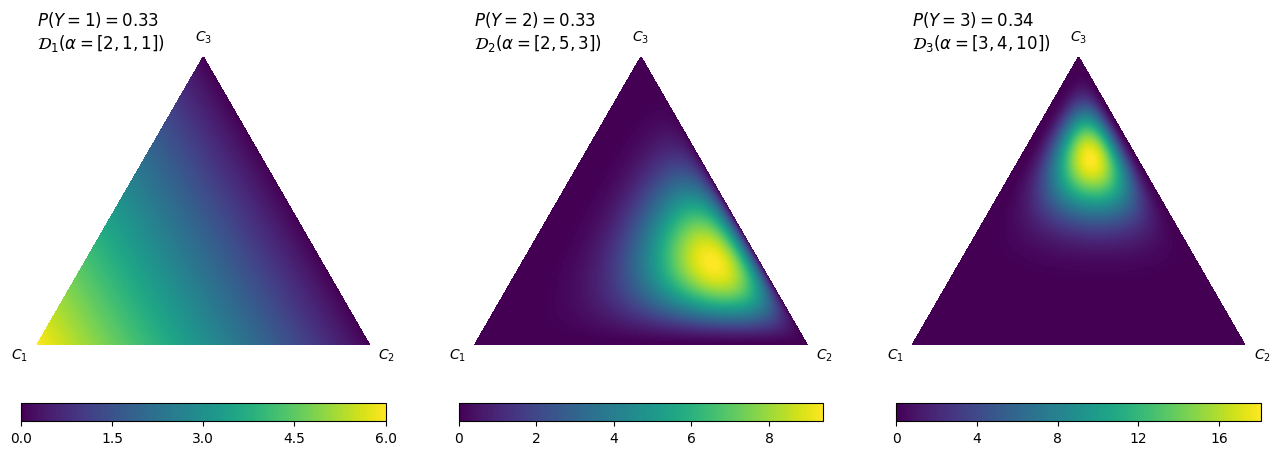

In [4]:
def plot_individual_pdfs(class_dist):
    fig = plt.figure(figsize=(16, 5))
    for i, (p, d) in enumerate(zip(class_dist.priors, class_dist.distributions)):
        ax = fig.add_subplot(1, len(class_dist.distributions), i+1)
        ax.set_title('$P(Y={})={}$\n$\\mathcal{{D}}_{}(\\alpha={})$'.format(i+1, p, i+1, str(d)), loc='left')
        draw_pdf_contours(d, labels='auto', fig=fig, ax=ax)
        
plot_individual_pdfs(class_dist)

# Joint probability density function

$$
f_{MD}(x_1, \dots, x_C; \mathcal{D}_1,  \dots, \mathcal{D}_C) = 
    \sum_{i=1}^C P(Y=i)\mathcal{D}_i(\mathbf{x})
$$

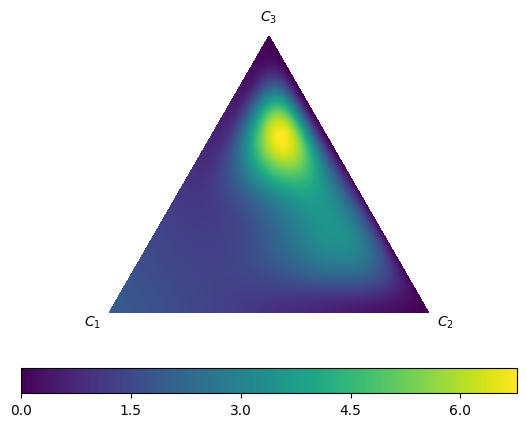

In [5]:
draw_pdf_contours(class_dist, labels='auto')

# Posterior probabilities per class

- And Converging lines to each class, from the oposite side of the simplex

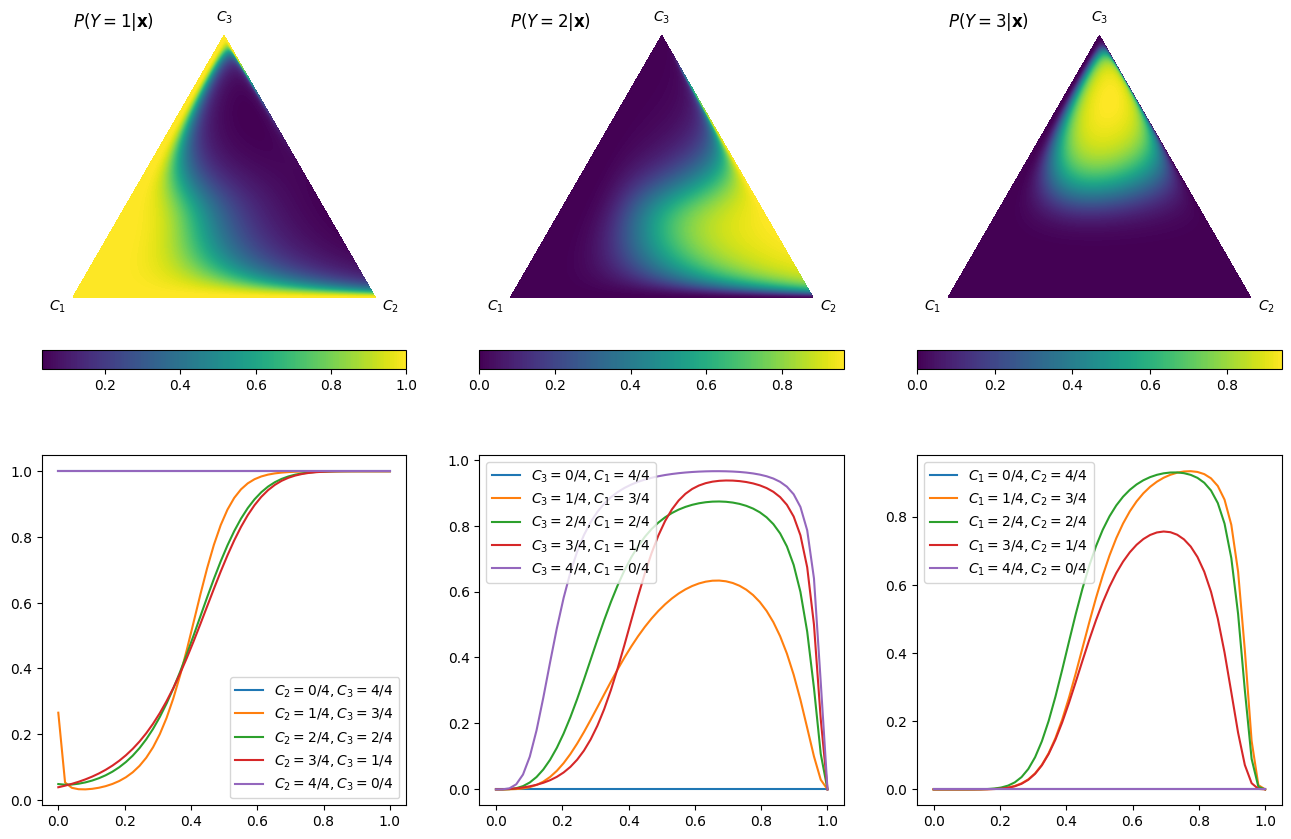

In [6]:
def plot_converging_lines_pvalues(func, lines, i, ax):
    '''
    Plots the probability values of the given function for each given line.
    The i indicates the class index from 0 to 2
    '''
    # This orders the classes in the following manner:
    # C1, C2, C3
    # C2, C3, C1
    # C3, C1, C2
    classes = np.roll(np.array([0, 1, 2]), -i)
    
    for j, line in enumerate(lines):
        pvalues = np.array([func(p) for p in line]).flatten()
        ax.plot(line[:,i], pvalues, 
                label=r'$C_{} = {}/{}, C_{} = {}/{}$'.format(
                    classes[1]+1, j, len(lines)-1,
                    classes[2]+1, len(lines)-j-1, len(lines)-1))
    ax.legend()

def get_converging_lines(num_lines, mesh_precision=10, class_index=0, tol=1e-9):
    '''
    If class_index = 0
    Create isometric lines from the oposite side of C1 simplex to the C1 corner
    First line has C2 fixed to 0
    Last line has C3 fixed to 0                                       
          Class 3  line 1 start                           
                 /\                                  
                /  \                                 
               /    \ line 2 start                        
              /    - \                               
             /   -/   \                              
            /  -/      \                             
           / -/      ---\ line 3 start                    
          /-/  -----/    \                           
         //---/           \                          
        -------------------- line 4 start                 
    Class 1(lines' end)      Class 2
    
    Else if class_index = [1, 2]
    Then the previusly described lines are rotated towards the indicated class.
    The lines always follow a clockwise order.
    '''
    p = np.linspace(0, 1, mesh_precision).reshape(-1, 1)
    q = np.linspace(0, 1, num_lines).reshape(-1, 1)
    lines = [np.hstack((p, (1-p)*q[i], (1-p)*(1-q[i]))) for i in range(len(q))]
    if class_index > 0:
        indices = np.array([0, 1, 2])
        lines = [line[:, np.roll(indices, class_index)] for i, line in enumerate(lines)]
    return np.clip(lines, tol, 1-tol)


indices = np.array([0, 1, 2])
fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(('C1', 'C2', 'C3')):
    ax1 = fig.add_subplot(2, 3, i+1)
    
    ax1.set_title('$P(Y={}|\mathbf{{x}})$'.format(i+1), loc='left')
    
    function = lambda x: class_dist.posterior(x, i)
    draw_func_contours(function, labels='auto', fig=fig, ax=ax1)
    
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    
    function = lambda x: class_dist.posterior(x, i).reshape(-1,1)
    lines = get_converging_lines(num_lines=5, mesh_precision=50, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)

# Marginals per class

- This are the aggregatred points per each class

E.g. All the scores s2, and s3, are aggregated with the same s1, and the probability of C1 is shown

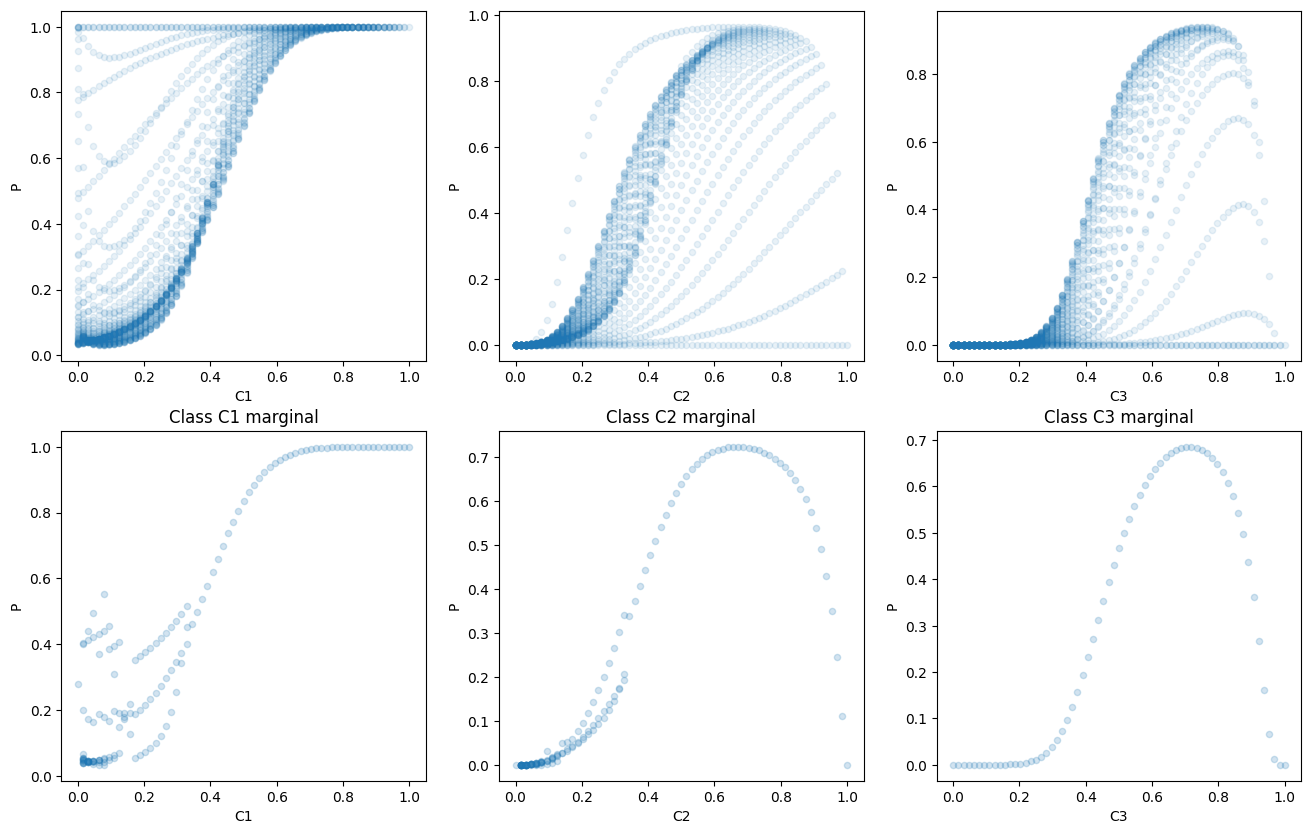

In [7]:
def plot_marginal(func, mesh, c, ax1, ax2):
    values = np.array([func(bc) for bc in mesh]).reshape(-1, 1)

    df = pd.DataFrame(np.concatenate((mesh, values), axis=1),
                      columns=['C1', 'C2', 'C3', 'P'])
    df.plot(kind='scatter', x=c, y='P', alpha=0.1, ax=ax1)

    ax2.set_title('Class {} marginal'.format(c))
    table = df.pivot_table(index=c, values='P')
    table.reset_index(inplace=True)
    table.columns = [c, 'P']
    table.plot(kind='scatter', x=c, y='P', alpha=0.2, ax=ax2)
    
    
mesh = get_mesh_bc(subdiv=subdiv)

fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(('C1', 'C2', 'C3')):
    ax1 = fig.add_subplot(2, 3, i+1)
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    
    function = lambda x: class_dist.posterior(x, i)
    plot_marginal(function, mesh, c, ax1, ax2)
    

# Sampling

Here we will generate some samples that can be used to train different multi-class calibration methods. First, we will visualise the samples in the simplex.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


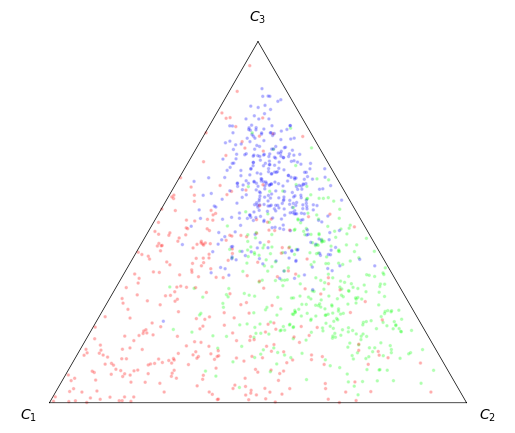

In [8]:
N = 1000
scores, classes = class_dist.sample(N)

draw_tri_samples(scores, classes, s=10, marker='.', alpha=0.2)

# Training a Multinomial Logistic Regression + L2

In [9]:
models = {}
mse = {}

In [10]:
from sklearn.linear_model import LogisticRegression
# Turn up tolerance for faster convergence
# Turn up tolerance for faster convergence
name = 'lr'
models[name] = LogisticRegression(C=99999999999,
                         multi_class='multinomial',
                         solver='saga')
clf = models[name]
clf.fit(scores, classes.argmax(axis=1))
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(scores, classes.argmax(axis=1))
print('Score = {}'.format(score))
print('Coeficients = \n{}'.format(clf.coef_))
print('Intercepts = {}'.format(clf.intercept_))

Score = 0.75
Coeficients = 
[[ 4.98544547 -1.7566758  -2.86506617]
 [-1.51989219  3.71410013 -2.00117299]
 [-3.46555328 -1.95742433  4.86623917]]
Intercepts = [ 0.36370349  0.19303495 -0.55673844]


/home/estienne/anaconda3/envs/llmcal/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Prediction space per class

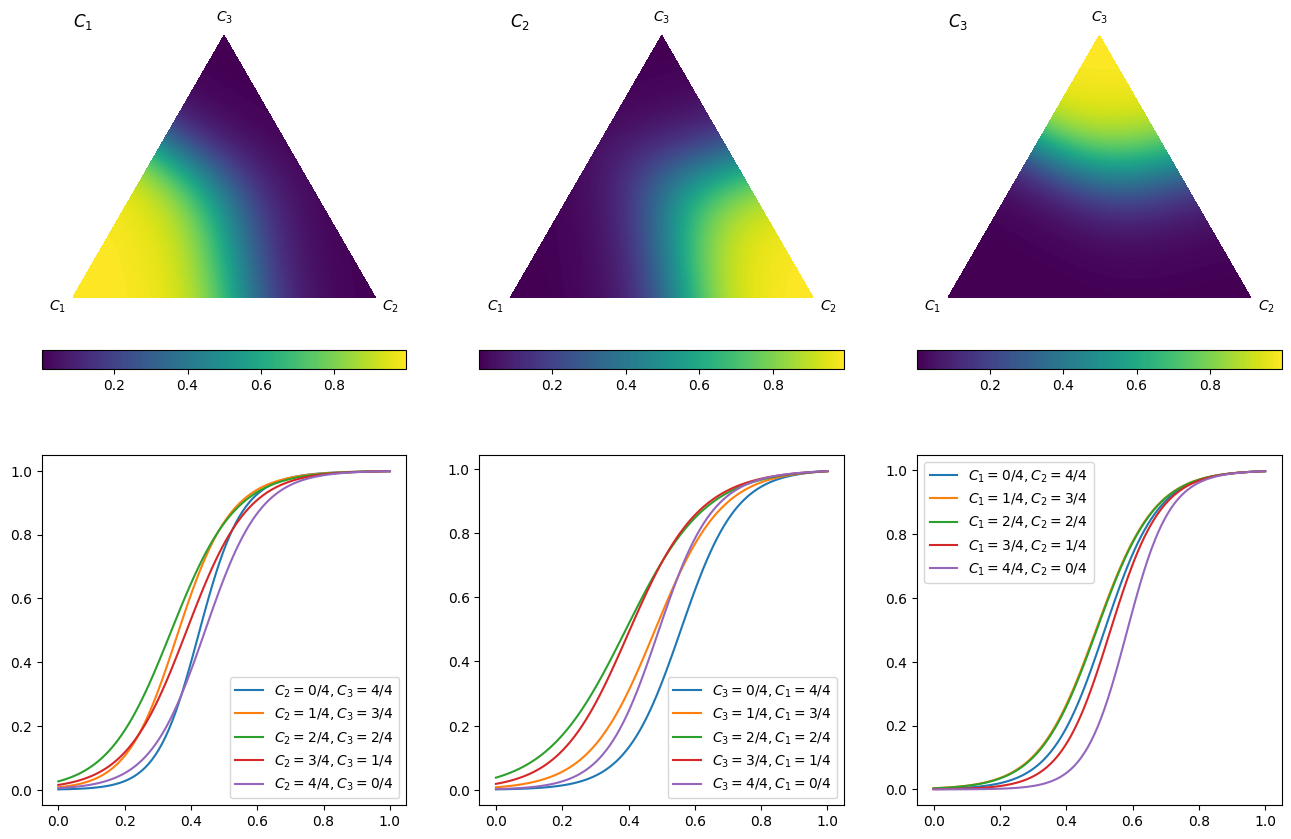

In [11]:
fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(('C1', 'C2', 'C3')):
    ax1 = fig.add_subplot(2, 3, i+1)
    
    ax1.set_title('$C_{}$'.format(i+1), loc='left')
    
    function = lambda x: clf.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax1)
    
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=nlevels, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)
    
    #ax3 = fig.add_subplot(4, 3, 6+i+1)
    #ax4 = fig.add_subplot(4, 3, 9+i+1)
    #plot_marginal(function, mesh, c, ax3, ax4)

## Squared error between true posterior and predicted probabilities

Mean Squred Error with all classes = 0.0407228503421024


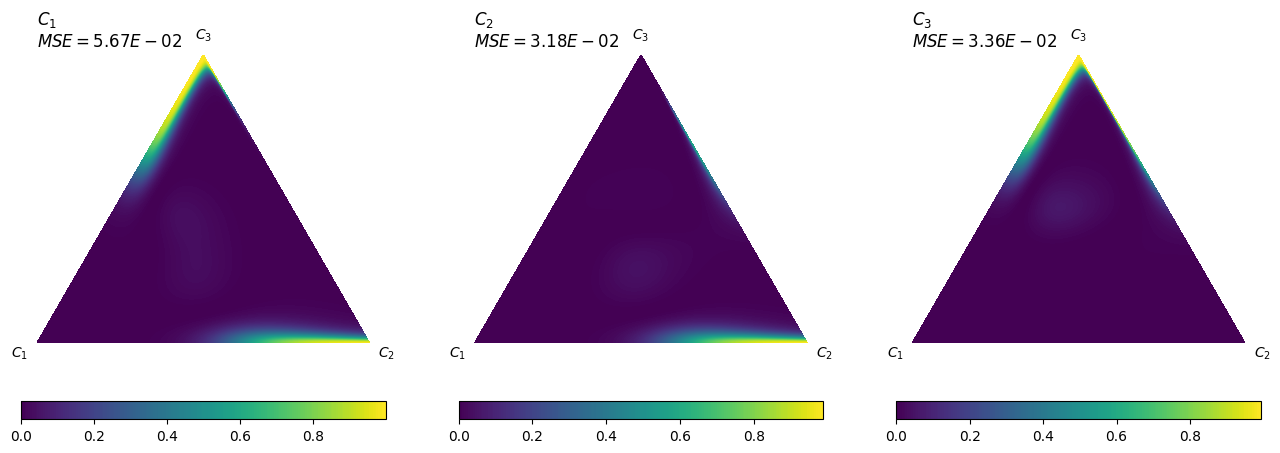

In [12]:
mesh_bc = get_mesh_bc()

orig_pvals = np.array([[class_dist.posterior(bc, c=i) for i in [0, 1, 2]] for bc in mesh_bc])
pred_pvals = clf.predict_proba(mesh_bc)

mse[name] = np.mean((orig_pvals - pred_pvals)**2, axis=0)

fig = plt.figure(figsize=(16, 5))
for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$C_{}$\n$MSE={:.2E}$'.format(i+1, mse[name][i]), loc='left')
    
    func = lambda x: (class_dist.posterior(x, i) - clf.predict_proba(x.reshape(1,-1))[0][i])**2

    draw_func_contours(func, labels='auto', fig=fig, ax=ax)
    
print('Mean Squred Error with all classes = {}'.format(mse[name].mean()))

# Training a Multinomial Logistic Regression + L2 in Logit space

In [13]:
class DirichletRegressionLogit(LogisticRegression):
    def fit(self, X, *args, **kwargs):
        return super(DirichletRegressionLogit, self).fit(np.log(X / (1 - X)), *args, **kwargs)
        
    def predict_proba(self, X, *args, **kwargs):
        return super(DirichletRegressionLogit, self).predict_proba(np.log(X / (1 - X)), *args, **kwargs)

/home/maikel/git/uob/dirichlet_cal_experiments/venv/lib/python3.4/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score = 0.346
Coeficients = 
[[-1.12592018 -2.59830464 -3.12183866]
 [-0.07220723  1.14664796 -0.49523758]
 [ 1.19812741  1.45165668  3.61707624]]
Intercepts = [-4.83010766  0.86064644  3.96946122]


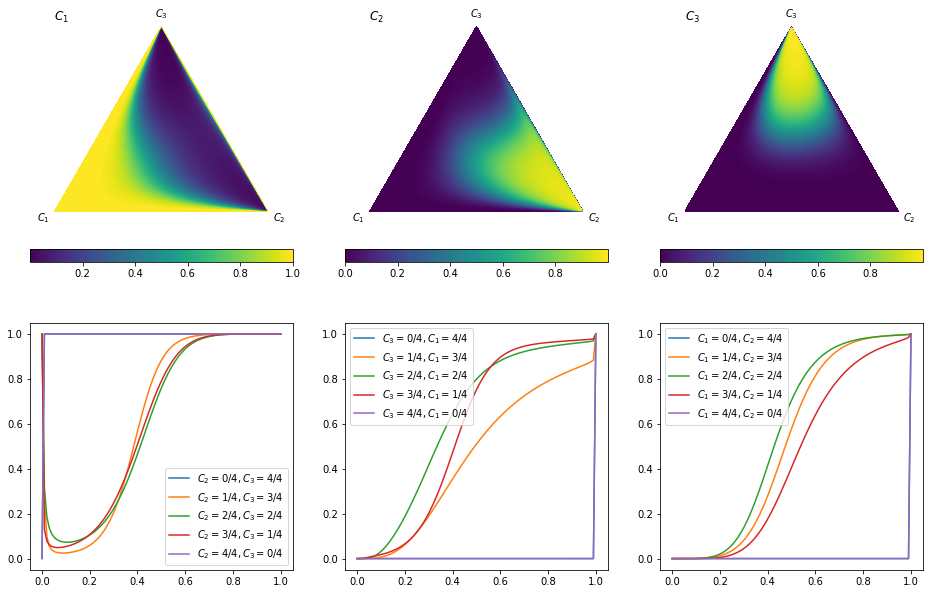

In [14]:
# Turn up tolerance for faster convergence
name = 'lr_logit'
models[name] = DirichletRegressionLogit(C=99999999999,
                         multi_class='multinomial', solver='saga')

clf = models[name]
clf.fit(scores, classes.argmax(axis=1))
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(scores, classes.argmax(axis=1))
print('Score = {}'.format(score))
print('Coeficients = \n{}'.format(clf.coef_))
print('Intercepts = {}'.format(clf.intercept_))

fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)
    
    ax.set_title('$C_{}$'.format(i+1), loc='left')
    
    function = lambda x: clf.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax)
    
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=nlevels, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)
    
    #ax2 = fig.add_subplot(3, 3, 3+i+1)
    #ax3 = fig.add_subplot(3, 3, 6+i+1)
    #plot_marginal(function, mesh, c, ax2, ax3)

## Squared error between true posterior and predicted probabilities

Mean Squred Error with all classes = 0.011244433084581456


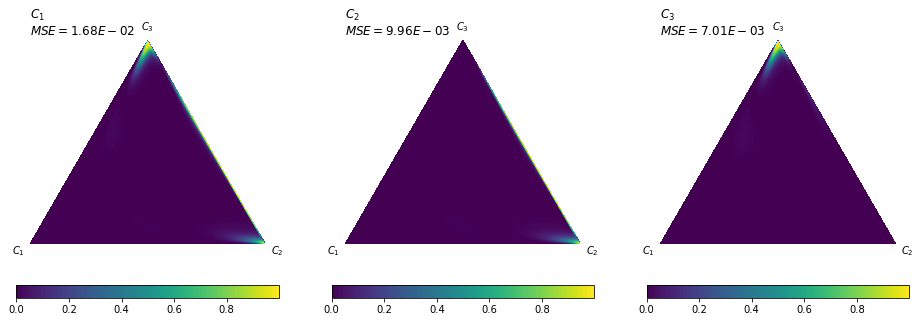

In [15]:
mesh_bc = get_mesh_bc()

orig_pvals = np.array([[class_dist.posterior(bc, c=i) for i in [0, 1, 2]] for bc in mesh_bc])
pred_pvals = clf.predict_proba(mesh_bc)

mse[name] = np.mean((orig_pvals - pred_pvals)**2, axis=0)
print('Mean Squred Error with all classes = {}'.format(mse[name].mean()))

fig = plt.figure(figsize=(16, 5))
for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$C_{}$\n$MSE={:.2E}$'.format(i+1, mse[name][i]), loc='left')
    
    func = lambda x: (class_dist.posterior(x, i) - clf.predict_proba(x.reshape(1,-1))[0][i])**2

    draw_func_contours(func, labels='auto', fig=fig, ax=ax)

# Training a Multinomial Logistic Regression in Log space

/home/maikel/git/uob/dirichlet_cal_experiments/venv/lib/python3.4/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score = 0.346
Coeficients = 
[[-0.11995931 -2.35885408 -3.3025888 ]
 [-0.24819509  1.99421401 -1.12658888]
 [ 0.3681544   0.36464008  4.42917769]]
Intercepts = [-6.38409091  1.1992145   5.18487641]


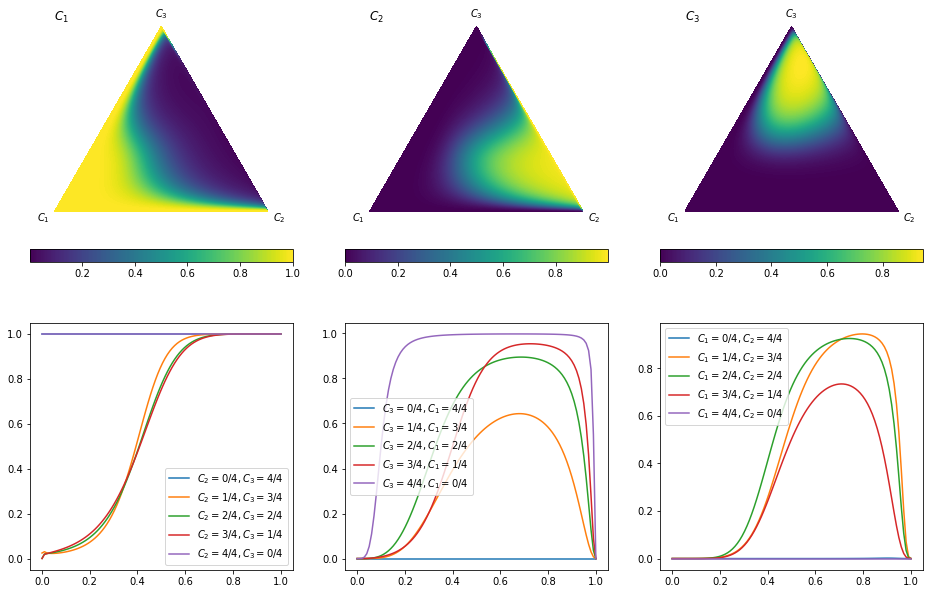

In [16]:
name = 'lr_log'
class DirichletRegressionLog(LogisticRegression):
    def fit(self, X, *args, **kwargs):
        return super(DirichletRegressionLog, self).fit(np.log(X), *args, **kwargs)
        
    def predict_proba(self, X, *args, **kwargs):
        return super(DirichletRegressionLog, self).predict_proba(np.log(X), *args, **kwargs)
    
# Turn up tolerance for faster convergence
models[name] = DirichletRegressionLog(C=99999999999,
                         multi_class='multinomial', solver='saga')

clf = models[name]
clf.fit(scores, classes.argmax(axis=1))
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(scores, classes.argmax(axis=1))
print('Score = {}'.format(score))
print('Coeficients = \n{}'.format(clf.coef_))
print('Intercepts = {}'.format(clf.intercept_))

fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)
    
    ax.set_title('$C_{}$'.format(i+1), loc='left')
    
    function = lambda x: clf.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax)
    
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=nlevels, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)
    
    #ax2 = fig.add_subplot(3, 3, 3+i+1)
    #ax3 = fig.add_subplot(3, 3, 6+i+1)
    #plot_marginal(function, mesh, c, ax2, ax3)

## Squared error between true posterior and predicted probabilities

Mean Squred Error with all classes = 0.0008136048829888112


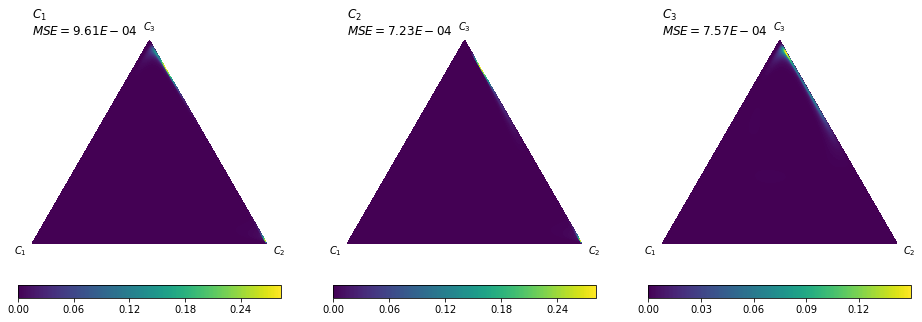

In [17]:
mesh_bc = get_mesh_bc()

orig_pvals = np.array([[class_dist.posterior(bc, c=i) for i in [0, 1, 2]] for bc in mesh_bc])
pred_pvals = clf.predict_proba(mesh_bc)

mse[name] = np.mean((orig_pvals - pred_pvals)**2, axis=0)
print('Mean Squred Error with all classes = {}'.format(mse[name].mean()))

fig = plt.figure(figsize=(16, 5))
for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$C_{}$\n$MSE={:.2E}$'.format(i+1, mse[name][i]), loc='left')
    
    func = lambda x: (class_dist.posterior(x, i) - clf.predict_proba(x.reshape(1,-1))[0][i])**2

    draw_func_contours(func, labels='auto', fig=fig, ax=ax)

# Training a Multinomial Logistic Regression in Odds space

/home/maikel/git/uob/dirichlet_cal_experiments/venv/lib/python3.4/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score = 0.599
Coeficients = 
[[ 3.36384782  1.00176775  0.50181564]
 [-1.38145469  0.6189625  -1.24547417]
 [-1.98239312 -1.62073025  0.74365854]]
Intercepts = [-2.4474138   1.34928711  1.09812669]


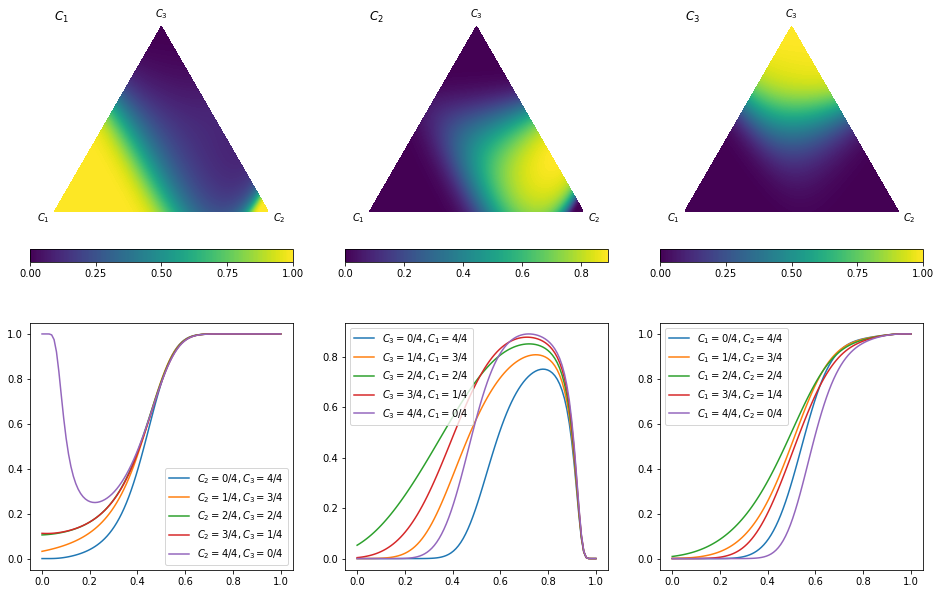

In [18]:
name = 'lr_odds'
class DirichletRegressionOdds(LogisticRegression):
    def fit(self, X, *args, **kwargs):
        return super(DirichletRegressionOdds, self).fit(X/(1-X), *args, **kwargs)
        
    def predict_proba(self, X, *args, **kwargs):
        return super(DirichletRegressionOdds, self).predict_proba(X/(1-X), *args, **kwargs)
    
# Turn up tolerance for faster convergence
models[name] = DirichletRegressionOdds(C=99999999999,
                         multi_class='multinomial', solver='saga')

clf = models[name]
clf.fit(scores, classes.argmax(axis=1))
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(scores, classes.argmax(axis=1))
print('Score = {}'.format(score))
print('Coeficients = \n{}'.format(clf.coef_))
print('Intercepts = {}'.format(clf.intercept_))

fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)
    
    ax.set_title('$C_{}$'.format(i+1), loc='left')
    
    function = lambda x: clf.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax)
    
    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=nlevels, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)
    
    #ax2 = fig.add_subplot(3, 3, 3+i+1)
    #ax3 = fig.add_subplot(3, 3, 6+i+1)
    #plot_marginal(function, mesh, c, ax2, ax3)

## Squared error between true posterior and predicted probabilities

Mean Squred Error with all classes = 0.03137077523387358


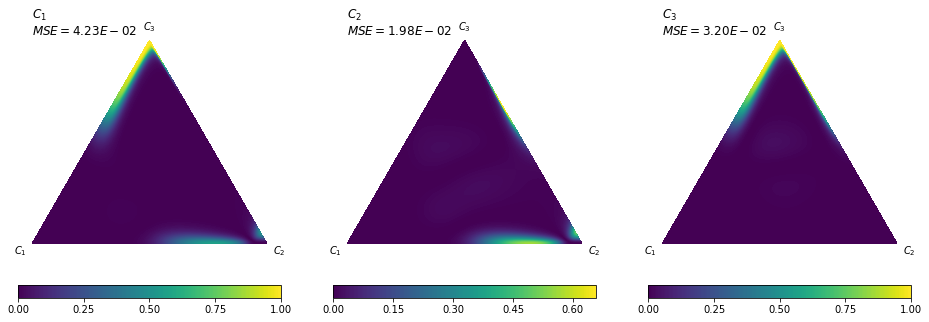

In [19]:
mesh_bc = get_mesh_bc()

orig_pvals = np.array([[class_dist.posterior(bc, c=i) for i in [0, 1, 2]] for bc in mesh_bc])
pred_pvals = clf.predict_proba(mesh_bc)

mse[name] = np.mean((orig_pvals - pred_pvals)**2, axis=0)
print('Mean Squred Error with all classes = {}'.format(mse[name].mean()))

fig = plt.figure(figsize=(16, 5))
for i in [0, 1, 2]:
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.set_title('$C_{}$\n$MSE={:.2E}$'.format(i+1, mse[name][i]), loc='left')
    
    func = lambda x: (class_dist.posterior(x, i) - clf.predict_proba(x.reshape(1,-1))[0][i])**2

    draw_func_contours(func, labels='auto', fig=fig, ax=ax)

# Results

These are the Mean Squared Errors per class between the true posterior probabilities and the predictions of the models

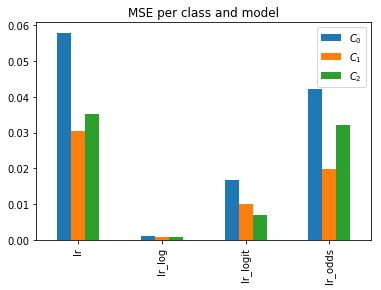

In [20]:
df_mse = pd.DataFrame(mse, index=['$C_0$', '$C_1$', '$C_2$']).T

df_mse.plot(kind='bar', title='MSE per class and model')

# Performance with different number of samples

Here we test the performance of all the methods with different number of samples drawn from the same distribution.

In case that the samples do not contain at least one sample per class the models are not compared.

/home/maikel/git/uob/dirichlet_cal_experiments/venv/lib/python3.4/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


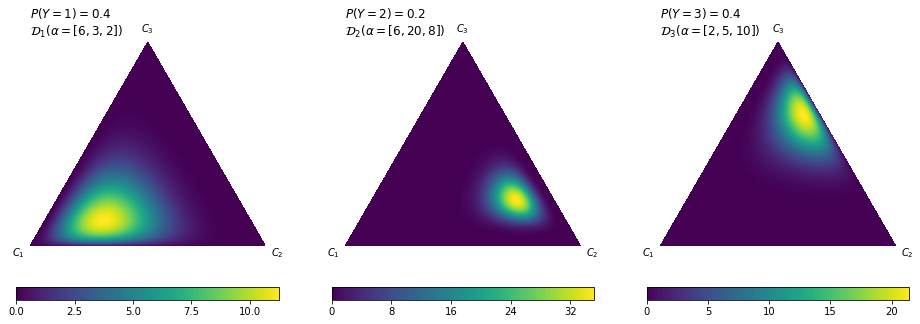

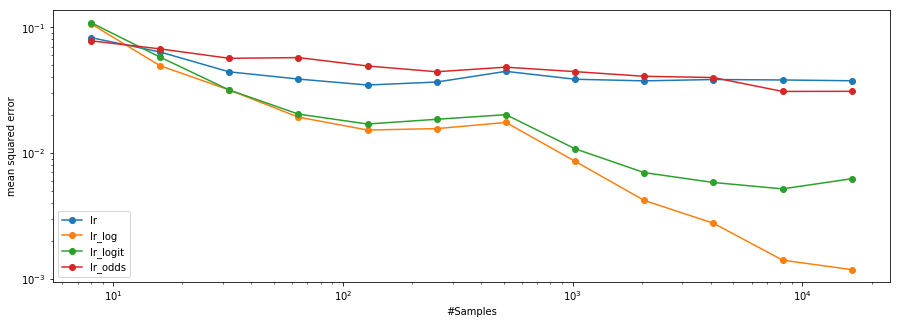

In [21]:
class_dist = MixtureDistribution([0.4, 0.2, 0.4], 
                                  (Dirichlet([6, 3, 2]),     
                                   Dirichlet([6, 20, 8]), 
                                   Dirichlet([2, 5, 10])))

N_list = 2**np.arange(3,15)
mesh_bc = get_mesh_bc()

def test_different_samples(N_list, class_dist): 
    mse = {key: np.zeros(len(N_list)) for key in models.keys()}
    
    orig_pvals = np.array([[class_dist.posterior(bc, c=i) for i in [0, 1, 2]] for bc in mesh_bc])

    for i, n in enumerate(N_list):
        scores, classes = class_dist.sample(n)
        classes = classes.argmax(axis=1)
        if len(np.unique(classes)) < 3:
            for key in models.keys():
                mse[key][i] = np.nan
            continue
        for key, model in models.items():
            model.fit(scores, classes)

            pred_pvals = model.predict_proba(mesh_bc)

            mse[key][i] = np.mean((orig_pvals - pred_pvals)**2)

    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    df_mse = pd.DataFrame(mse)
    df_mse.index = N_list
    df_mse.plot(ax=ax, marker='o', logy=True, logx=True)
    ax.set_xlabel('#Samples')
    ax.set_ylabel('mean squared error')

plot_individual_pdfs(class_dist)
test_different_samples(N_list, class_dist)

# Performance with different number of samples and other Mixture of Dirichlet distributions

/home/maikel/git/uob/dirichlet_cal_experiments/venv/lib/python3.4/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


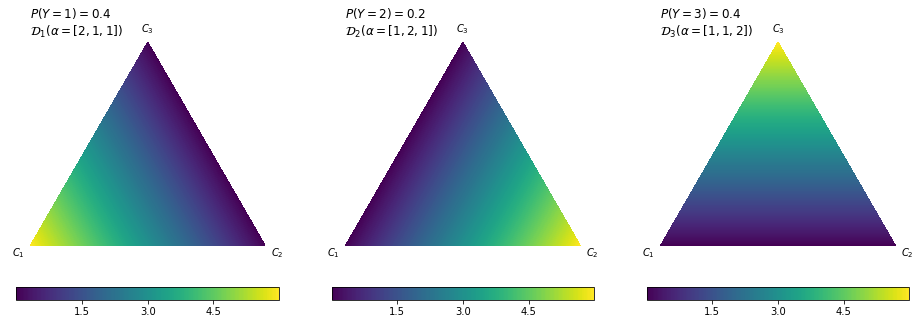

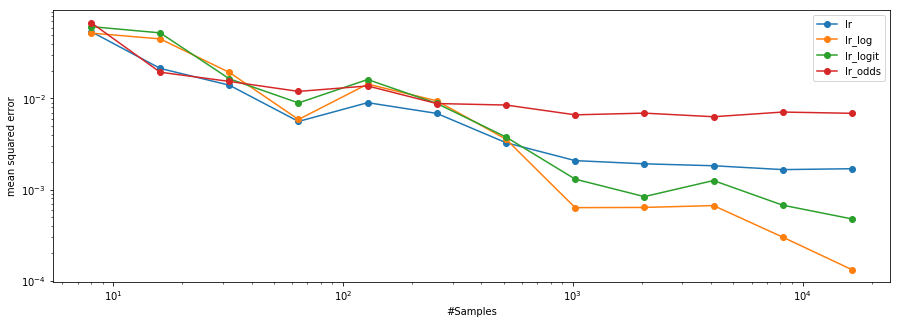

In [22]:
class_dist = MixtureDistribution([0.4, 0.2, 0.4], 
                                  (Dirichlet([2, 1, 1]),     
                                   Dirichlet([1, 2, 1]), 
                                   Dirichlet([1, 1, 2])))

plot_individual_pdfs(class_dist)
test_different_samples(N_list, class_dist)

/home/maikel/git/uob/dirichlet_cal_experiments/venv/lib/python3.4/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


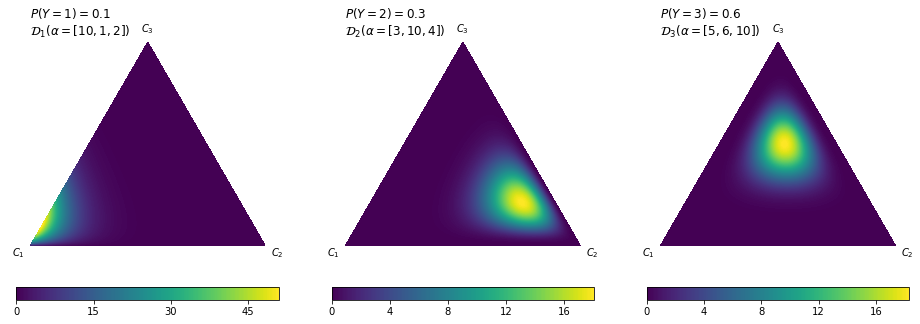

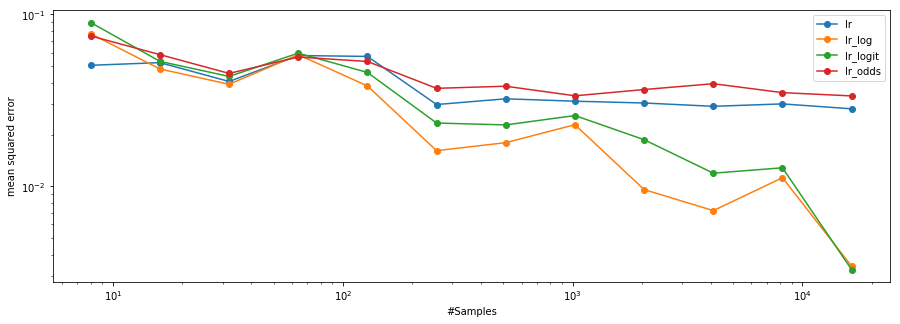

In [23]:
class_dist = MixtureDistribution([0.1, 0.3, 0.6], 
                                  (Dirichlet([10, 1, 2]),     
                                   Dirichlet([3, 10, 4]), 
                                   Dirichlet([5, 6, 10])))

plot_individual_pdfs(class_dist)
test_different_samples(N_list, class_dist)